<a href="https://colab.research.google.com/github/Alia-Liban/Applied-informatics/blob/main/HighStroke_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE


In [2]:
from google.colab import files
uploaded = files.upload()

Saving cardio_train.csv to cardio_train.csv


In [3]:
df = pd.read_csv("cardio_train.csv", sep=';')
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [13]:
df = pd.read_csv("cardio_train.csv", sep=';')
df['age'] = df['age'] //365  #change from days to years
df.drop(["id"],axis=1,inplace=True)
df = df.rename(columns={
    'ap_hi': 'systolic',
    'ap_lo': 'diastolic',
    'cholesterol': 'chol',
    'gluc': 'gluc'
})
#take care of the medical limits
df = df[
    (df['height'] >= 120) & (df['height'] <= 220) &
    (df['weight'] >= 30) & (df['weight'] <= 200) &
    (df['systolic'] >= 70) & (df['systolic'] <= 250) &
    (df['diastolic'] >= 40) & (df['diastolic'] <= 150)
]


df['BMI'] = df['weight'] / ((df['height'] / 100) ** 2)
(df['BMI'] >= 10) & (df['BMI'] <= 60)


print("After cleaning:", df.shape)
df.isnull().sum()

After cleaning: (68698, 13)


age          0
gender       0
height       0
weight       0
systolic     0
diastolic    0
chol         0
gluc         0
smoke        0
alco         0
active       0
cardio       0
BMI          0
dtype: int64

In [14]:
#Dataset statistics
print("\nDataset Types:\n")
print(df.dtypes)

print("\nMissing Values:\n")
print(df.isnull().sum())

print("\nDuplicate Rows:", df.duplicated().sum())


Dataset Types:

age            int64
gender         int64
height         int64
weight       float64
systolic       int64
diastolic      int64
chol           int64
gluc           int64
smoke          int64
alco           int64
active         int64
cardio         int64
BMI          float64
dtype: object

Missing Values:

age          0
gender       0
height       0
weight       0
systolic     0
diastolic    0
chol         0
gluc         0
smoke        0
alco         0
active       0
cardio       0
BMI          0
dtype: int64

Duplicate Rows: 3206


In [15]:
print("Before duplicates:", df.shape)
df.drop_duplicates(inplace=True)
print("After duplicates:", df.shape)


Before duplicates: (68698, 13)
After duplicates: (65492, 13)


In [16]:
#stroke symptons
df['risk_age']   = df['age'] > 55
df['risk_bp']    = (df['systolic'] >= 140) | (df['diastolic'] >= 90)
df['risk_chol']  = df['chol'] >= 2
df['risk_gluc']  = df['gluc'] >= 2
df['risk_bmi']   = df['BMI'] >= 30
df['risk_smoke'] = df['smoke'] == 1
df['risk_alco']  = df['alco'] == 1
#risk score
risk_cols = [
    'risk_age','risk_bp','risk_chol',
    'risk_gluc','risk_bmi','risk_smoke','risk_alco'
]

df['stroke_risk_score'] = df[risk_cols].sum(axis=1)
#binary target
df['high_stroke_risk'] = (df['stroke_risk_score'] >= 3).astype(int)




In [17]:
df.columns

Index(['age', 'gender', 'height', 'weight', 'systolic', 'diastolic', 'chol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'BMI', 'risk_age',
       'risk_bp', 'risk_chol', 'risk_gluc', 'risk_bmi', 'risk_smoke',
       'risk_alco', 'stroke_risk_score', 'high_stroke_risk'],
      dtype='object')

In [18]:
print("\nSUMMARY STATISTICS ") #outlier detection
print(df.describe())



SUMMARY STATISTICS 
                age        gender        height        weight      systolic  \
count  65492.000000  65492.000000  65492.000000  65492.000000  65492.000000   
mean      52.847691      1.355494    164.398904     74.435258    126.926495   
std        6.806271      0.478666      8.030855     14.483113     17.045658   
min       29.000000      1.000000    120.000000     30.000000     70.000000   
25%       48.000000      1.000000    159.000000     65.000000    120.000000   
50%       53.000000      1.000000    165.000000     72.000000    120.000000   
75%       58.000000      2.000000    170.000000     82.000000    140.000000   
max       64.000000      2.000000    207.000000    200.000000    240.000000   

          diastolic          chol          gluc         smoke          alco  \
count  65492.000000  65492.000000  65492.000000  65492.000000  65492.000000   
mean      81.440939      1.380825      1.235769      0.092118      0.056129   
std        9.744586      0.689

In [19]:
#EDA SECTION
# Shape and basic info
print("Dataset shape:", df.shape)
df.info()

# Target distribution
df['high_stroke_risk'].value_counts(normalize=True)


Dataset shape: (65492, 22)
<class 'pandas.core.frame.DataFrame'>
Index: 65492 entries, 0 to 69999
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                65492 non-null  int64  
 1   gender             65492 non-null  int64  
 2   height             65492 non-null  int64  
 3   weight             65492 non-null  float64
 4   systolic           65492 non-null  int64  
 5   diastolic          65492 non-null  int64  
 6   chol               65492 non-null  int64  
 7   gluc               65492 non-null  int64  
 8   smoke              65492 non-null  int64  
 9   alco               65492 non-null  int64  
 10  active             65492 non-null  int64  
 11  cardio             65492 non-null  int64  
 12  BMI                65492 non-null  float64
 13  risk_age           65492 non-null  bool   
 14  risk_bp            65492 non-null  bool   
 15  risk_chol          65492 non-null  bool   
 16  

high_stroke_risk
0    0.764674
1    0.235326
Name: proportion, dtype: float64

In [20]:
summary_stats = df.describe()
summary_stats


age        gender        height        weight      systolic  \
count  65492.000000  65492.000000  65492.000000  65492.000000  65492.000000   
mean      52.847691      1.355494    164.398904     74.435258    126.926495   
std        6.806271      0.478666      8.030855     14.483113     17.045658   
min       29.000000      1.000000    120.000000     30.000000     70.000000   
25%       48.000000      1.000000    159.000000     65.000000    120.000000   
50%       53.000000      1.000000    165.000000     72.000000    120.000000   
75%       58.000000      2.000000    170.000000     82.000000    140.000000   
max       64.000000      2.000000    207.000000    200.000000    240.000000   

          diastolic          chol          gluc         smoke          alco  \
count  65492.000000  65492.000000  65492.000000  65492.000000  65492.000000   
mean      81.440939      1.380825      1.235769      0.092118      0.056129   
std        9.744586      0.689076      0.581883      0.289195      0.230172   
min       40.000000      1.000000      1.000000      0.000000      0.000000   
25%       80.000000      1.000000      1.000000      0.000000      0.000000   
50%       80.000000      1.000000      1.000000      0.000000      0.000000   
75%       90.000000      2.000000      1.000000      0.000000      0.000000   
max      150.000000      3.000000      3.000000      1.000000      1.000000   

             active        cardio           BMI  stroke_risk_score  \
count  65492.000000  65492.000000  65492.000000       65492.000000   
mean       0.798036      0.507024     27.582086           1.588866   
std        0.401468      0.499954      5.325425           1.315529   
min        0.000000      0.000000     10.726644           0.000000   
25%        1.000000      0.000000     23.875115           1.000000   
50%        1.000000      1.000000     26.562500           1.000000   
75%        1.000000      1.000000     30.443839           2.000000   
max        1.000000      1.000000    108.169847           7.000000   

       high_stroke_risk  
count      65492.000000  
mean           0.235326  
std            0.424206  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            0.000000  
max            1.000000

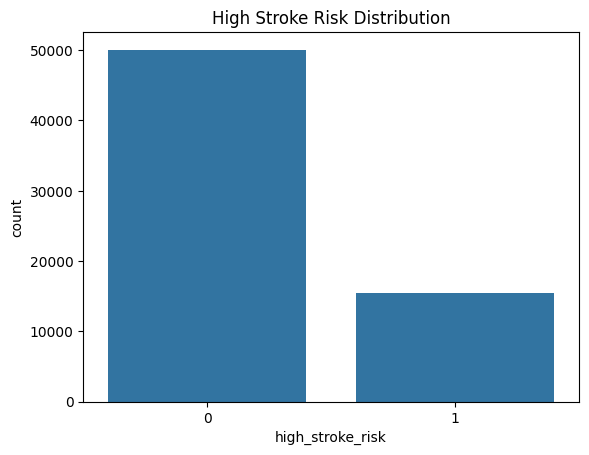

high_stroke_risk
0    50080
1    15412
Name: count, dtype: int64


In [21]:

sns.countplot(x='high_stroke_risk', data=df)  #our class is severly imbalanced with minority class being 22%
plt.title("High Stroke Risk Distribution")
plt.show()
print(df['high_stroke_risk'].value_counts())


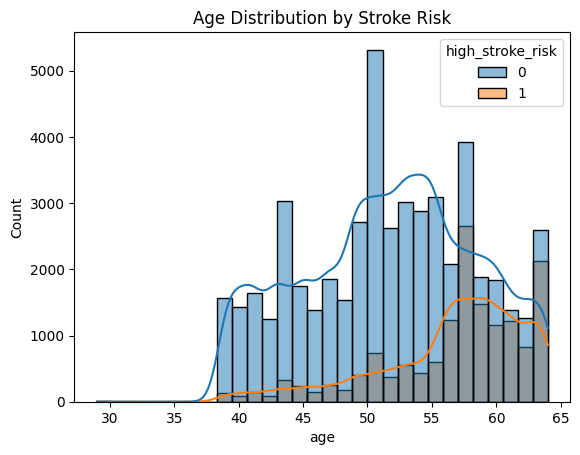

In [22]:
plt.figure()
sns.histplot(data=df, x='age', hue='high_stroke_risk', bins=30, kde=True)
plt.title("Age Distribution by Stroke Risk")
plt.show()



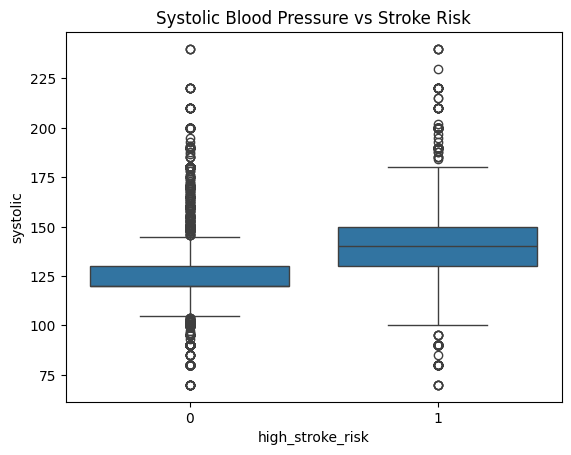

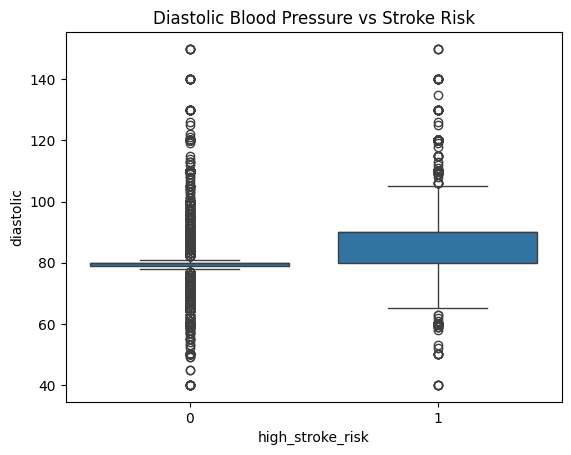

In [23]:
plt.figure()
sns.boxplot(x='high_stroke_risk', y='systolic', data=df)
plt.title("Systolic Blood Pressure vs Stroke Risk")
plt.show()

plt.figure()
sns.boxplot(x='high_stroke_risk', y='diastolic', data=df)
plt.title("Diastolic Blood Pressure vs Stroke Risk")
plt.show()


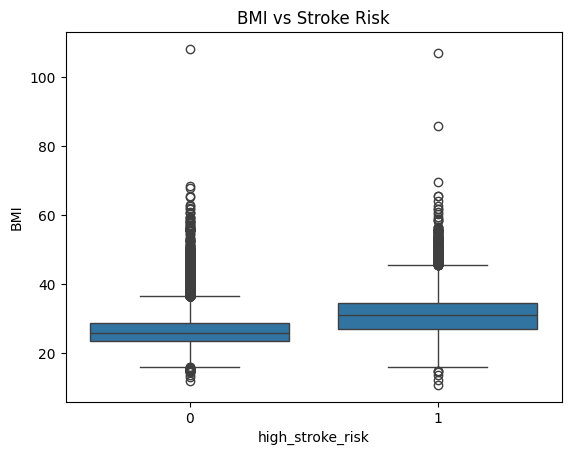

In [24]:
plt.figure()
sns.boxplot(x='high_stroke_risk', y='BMI', data=df)
plt.title("BMI vs Stroke Risk")
plt.show()


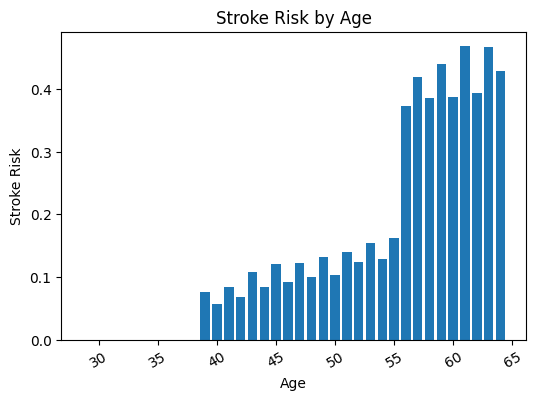

age
55    3695
53    3563
57    3433
59    3365
56    3318
54    3312
58    3152
51    3133
49    3124
60    3004
52    2992
50    2923
63    2645
61    2607
47    2111
62    2096
64    2077
45    1988
43    1933
41    1787
48    1709
39    1694
46    1534
40    1522
44    1435
42    1336
29       3
30       1
Name: count, dtype: int64


In [25]:
age_stroke_distribution = df.groupby('age')['high_stroke_risk'].mean()

plt.figure(figsize=(6,4)) #relationship b/w strpke risk and age
plt.bar(age_stroke_distribution.index, age_stroke_distribution.values)
plt.title("Stroke Risk by Age")
plt.xlabel("Age")
plt.ylabel("Stroke Risk")
plt.xticks(rotation=30)
plt.show()
print(df["age"].value_counts())

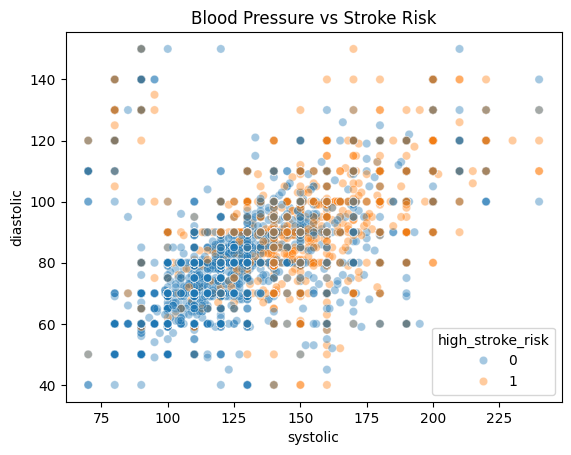

In [26]:
sns.scatterplot(
    x='systolic', y='diastolic',
    hue='high_stroke_risk',
    data=df, alpha=0.4
)
plt.title("Blood Pressure vs Stroke Risk")
plt.show()


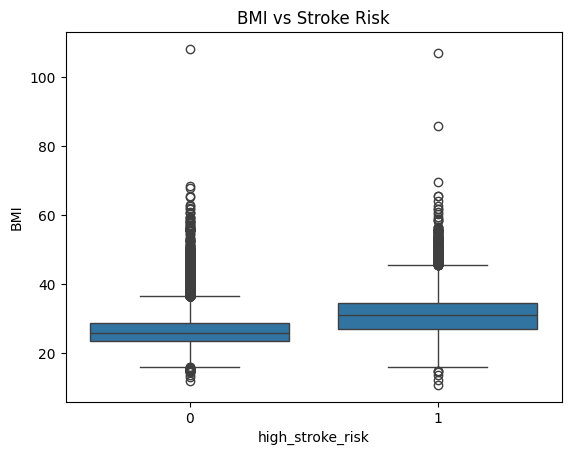

In [27]:
sns.boxplot(x='high_stroke_risk', y='BMI', data=df)
plt.title("BMI vs Stroke Risk")
plt.show()


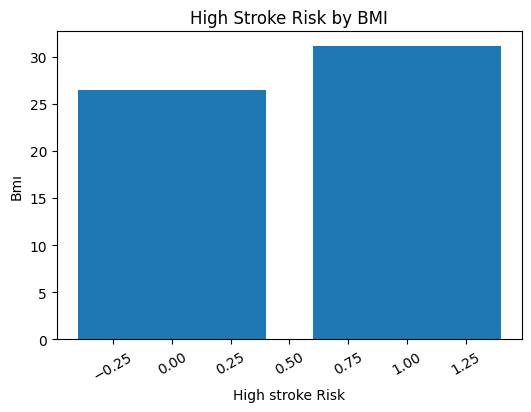

BMI
23.875115    568
23.437500    415
24.221453    367
25.711662    306
24.801587    299
            ... 
38.525565      1
27.423823      1
37.934626      1
47.218917      1
38.302384      1
Name: count, Length: 3730, dtype: int64


In [28]:
BMIstroke_distribution = df.groupby('high_stroke_risk')['BMI'].mean()

plt.figure(figsize=(6,4)) #relationship b/w
plt.bar(BMIstroke_distribution.index, BMIstroke_distribution.values)
plt.title("High Stroke Risk by BMI")
plt.xlabel("High stroke Risk")
plt.ylabel("Bmı")
plt.xticks(rotation=30)
plt.show()
print(df["BMI"].value_counts())

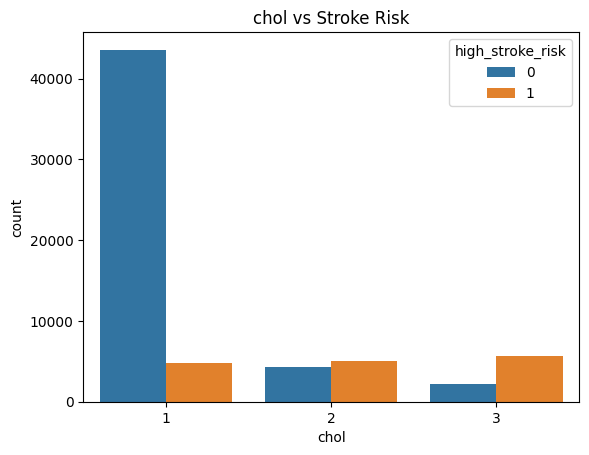

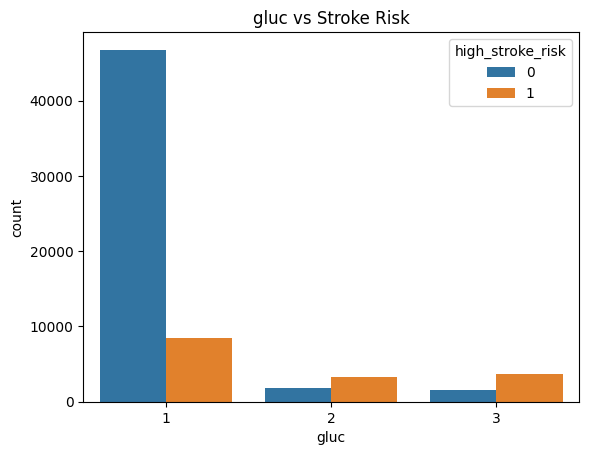

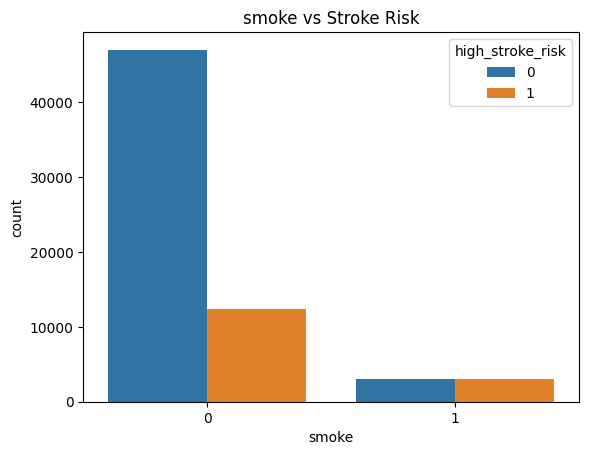

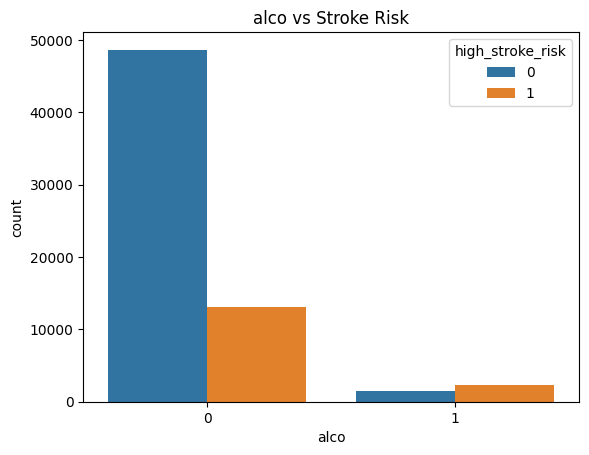

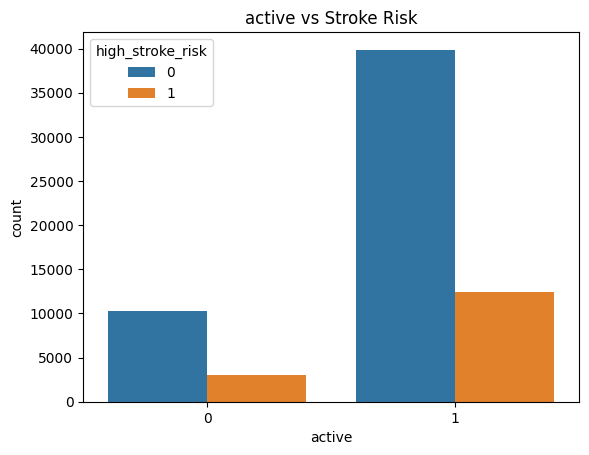

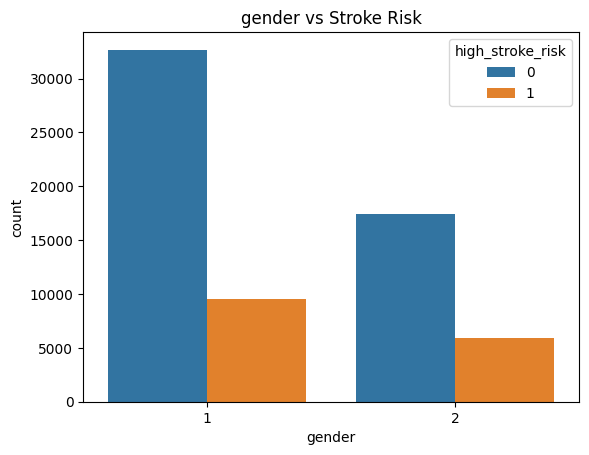

In [29]:
cat_features = ['chol','gluc','smoke','alco','active','gender']

for col in cat_features:
    sns.countplot(x=col, hue='high_stroke_risk', data=df)
    plt.title(f"{col} vs Stroke Risk")
    plt.show()


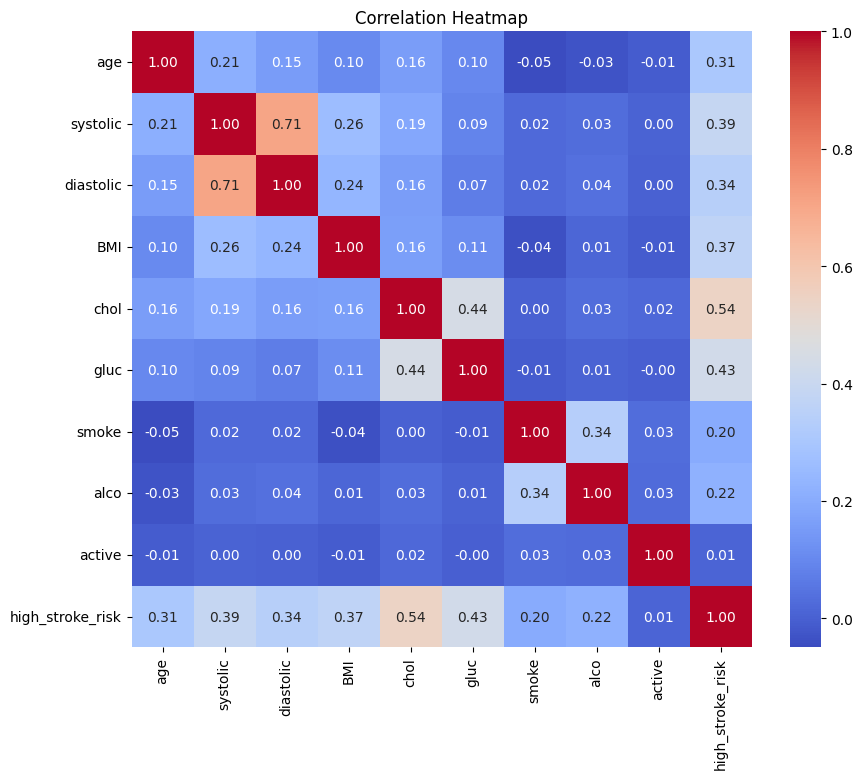

In [30]:
plt.figure(figsize=(10,8))
corr = df[['age','systolic','diastolic','BMI','chol','gluc','smoke','alco','active','high_stroke_risk']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()



In [31]:
X = df[['age','gender','smoke','alco','active']]

y = df['high_stroke_risk']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
num_features = ['age',]
cat_features = ['gender','alco','active','smoke']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ]
)
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled  = preprocessor.transform(X_test)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)



print("Training set:", X_train.shape)
print("Test set:", X_test.shape)



Training set: (52393, 5)
Test set: (13099, 5)


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


In [33]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(
    X_train_scaled, y_train
)


In [34]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

log_reg.fit(X_train_res, y_train_res)

y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1:", f1_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))



Logistic Regression
Accuracy: 0.7021910069470952
Precision: 0.4247608535688006
Recall: 0.7489458319818358
F1: 0.5420824040380327
ROC-AUC: 0.7712079420899314


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


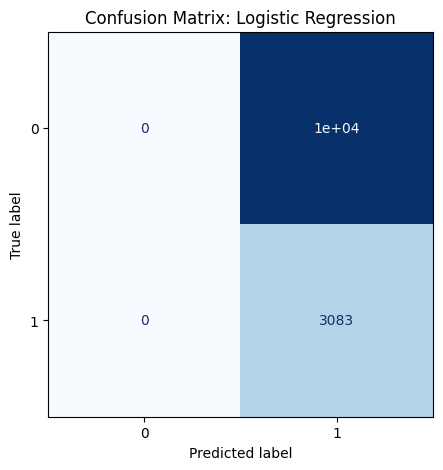

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test data
y_pred_lr = log_reg.predict(X_test)

# give the confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Display confusion matrix
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(5,5))
disp_lr.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title("Confusion Matrix: Logistic Regression")
plt.show()


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE

#no scaling
X_train_rf = X_train.copy()
X_test_rf  = X_test.copy()

# use SMOTE
smote = SMOTE(random_state=42)
X_train_rf_res, y_train_rf_res = smote.fit_resample(X_train_rf, y_train)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,          # prevent memorization
    min_samples_leaf=20,   # reduce overfitting
    random_state=42
)

rf.fit(X_train_rf_res, y_train_rf_res)

y_pred_rf = rf.predict(X_test_rf)
y_prob_rf = rf.predict_proba(X_test_rf)[:, 1]

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))



Random Forest
Accuracy: 0.6891365753110924
Precision: 0.41568627450980394
Recall: 0.7907881933181966
F1: 0.5449262405006705
ROC-AUC: 0.7771002982966471


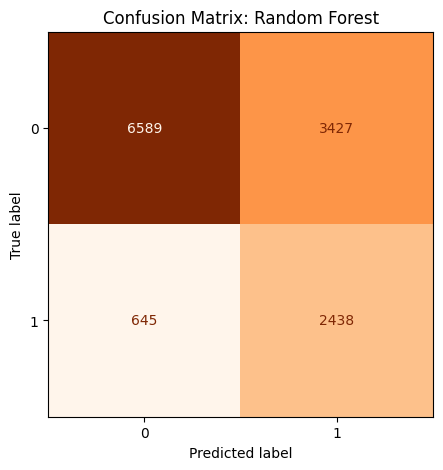

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Compute confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Display
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(5,5))
disp_rf.plot(ax=ax, cmap=plt.cm.Oranges, colorbar=False)
plt.title("Confusion Matrix: Random Forest")
plt.show()


In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb.fit(X_train_res, y_train_res)

y_pred_gb = gb.predict(X_test_scaled)
y_prob_gb = gb.predict_proba(X_test_scaled)[:, 1]

print("\nGradient Boosting")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Precision:", precision_score(y_test, y_pred_gb))
print("Recall:", recall_score(y_test, y_pred_gb))
print("F1:", f1_score(y_test, y_pred_gb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_gb))





Gradient Boosting
Accuracy: 0.6895946255439347
Precision: 0.4161691966570015
Recall: 0.7914369120986052
F1: 0.5454951933825173
ROC-AUC: 0.7783665175615222


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


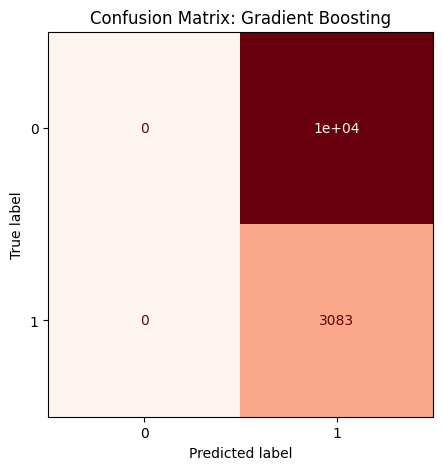

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test data
y_pred_gb = gb.predict(X_test)

# Compute confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)

# Display
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(5,5))
disp_gb.plot(ax=ax, cmap=plt.cm.Reds, colorbar=False)
plt.title("Confusion Matrix: Gradient Boosting")
plt.show()


In [40]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,          # PREVENT overfitting
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train_rf_res, y_train_rf_res)

y_pred_xgb = xgb.predict(X_test_rf)
y_prob_xgb = xgb.predict_proba(X_test_rf)[:, 1]

print("XGBoost")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1:", f1_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))



XGBoost
Accuracy: 0.6903580425986716
Precision: 0.4169369984633772
Recall: 0.792085630879014
F1: 0.5463087248322148
ROC-AUC: 0.7787354698910547


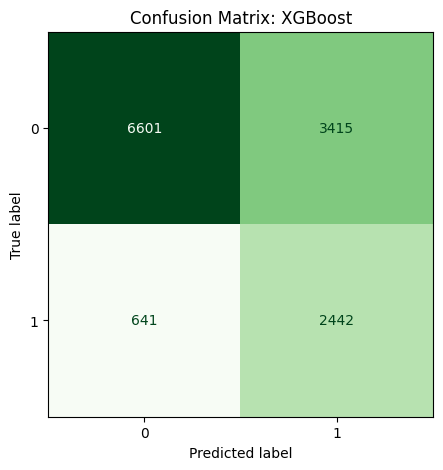

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test data
y_pred_xgb = xgb.predict(X_test)

# Compute confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Display
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(5,5))
disp_xgb.plot(ax=ax, cmap=plt.cm.Greens, colorbar=False)
plt.title("Confusion Matrix: XGBoost")
plt.show()


In [42]:
#stacking
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

base_models = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=200, random_state=42, max_depth=8
    )),
    ('gb', GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.05, random_state=42
    )),
    ('xgb', XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    ))
]


In [43]:
from sklearn.ensemble import StackingClassifier

meta_learner = LogisticRegression(max_iter=1000, random_state=42)

stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5,                    # prevents leakage
    stack_method='predict_proba',
    n_jobs=-1
)


In [44]:
stacking_clf.fit(X_train_res, y_train_res)

y_pred_stack = stacking_clf.predict(X_test_scaled)
y_prob_stack = stacking_clf.predict_proba(X_test_scaled)[:, 1]
print("\nSTACKING ENSEMBLE ")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Precision:", precision_score(y_test, y_pred_stack))
print("Recall:", recall_score(y_test, y_pred_stack))
print("F1:", f1_score(y_test, y_pred_stack))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_stack))




STACKING ENSEMBLE 
Accuracy: 0.6901290174822505
Precision: 0.4168370824812543
Recall: 0.7933830684398313
F1: 0.5465311138420288
ROC-AUC: 0.7774825928854411


100%|===================| 26194/26198 [09:33<00:00]       

100%|===================| 26185/26198 [09:39<00:00]       

<Figure size 640x480 with 0 Axes>

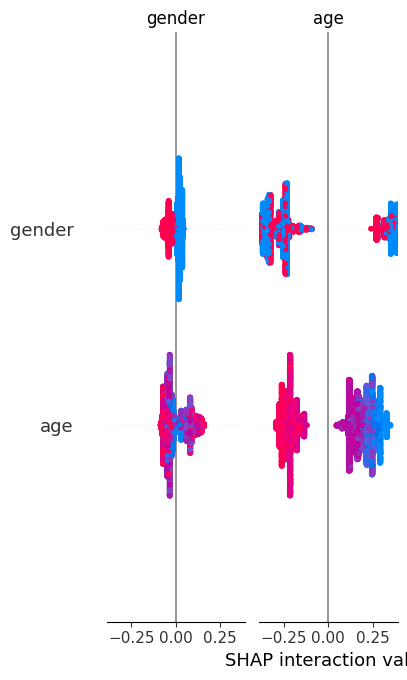

In [45]:
import shap
import matplotlib.pyplot as plt

# 1. Initialize SHAP (needed for notebooks, safe to keep)
shap.initjs()

X_background = X_train.sample(100, random_state=42)

# 3. Create TreeExplainer (BEST for RF, GB, XGB)
explainer = shap.TreeExplainer(rf, data=X_background)

# 4. Compute SHAP values on test set
shap_values = explainer.shap_values(X_test)

# 5. Handle binary classification
# For binary classification, SHAP returns a list → use index 1 (positive class)
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# 6. Summary plot (global feature importance)
import shap
import matplotlib.pyplot as plt

# 1. Initialize SHAP (needed for notebooks, safe to keep)
shap.initjs()

# 2. Use a small background dataset (important for stability & speed)
X_background = X_train.sample(100, random_state=42)

# 3. Create TreeExplainer (BEST for RF, GB, XGB)
explainer = shap.TreeExplainer(rf, data=X_background)

# 4. Compute SHAP values on test set
shap_values = explainer.shap_values(X_test)

# 5. Handle binary classification
# For binary classification, SHAP returns a list → use index 1 (positive class)
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# 6. Summary plot (global feature importance)
plt.figure()
shap.summary_plot(
    shap_values,
    X_test,
    feature_names=X_test.columns,
    show=True
)




In [46]:
!pip install lime



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=cc2ed170b3a3cd1e2f89800497a94b309d75642db1538a3a1af11d35ee851048
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [47]:
import numpy as np
import lime
import lime.lime_tabular

X_test_lime = X_test_scaled
X_train_lime = X_train_res   # SMOTE-resampled training data

feature_names = preprocessor.get_feature_names_out()
print(X_test_lime.shape)
print(len(feature_names))



(13099, 5)
5


In [48]:
from lime.lime_tabular import LimeTabularExplainer

#explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train_lime,
    feature_names=feature_names,
    class_names=['Low Stroke Risk', 'High Stroke Risk'],
    mode='classification',
    discretize_continuous=True
)

# choose example test instance
i = 0

exp = lime_explainer.explain_instance(
    data_row=X_test_lime[i],
    predict_fn=rf.predict_proba,
    num_features=10
)

# Show explanation
exp.show_in_notebook(show_table=True)



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [49]:
from lime.lime_tabular import LimeTabularExplainer

# Create explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train_lime,
    feature_names=feature_names,
    class_names=['Low Stroke Risk', 'High Stroke Risk'],
    mode='classification',
    discretize_continuous=True
)

# Choose test instance
i = 0

exp = lime_explainer.explain_instance(
    data_row=X_test_lime[i],
    predict_fn=gb.predict_proba,   #gradient boosting
    num_features=10
)

# Show explanation
exp.show_in_notebook(show_table=True)



In [50]:
from lime.lime_tabular import LimeTabularExplainer

# Create explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train_lime,
    feature_names=feature_names,
    class_names=['Low Stroke Risk', 'High Stroke Risk'],
    mode='classification',
    discretize_continuous=True
)

# Choose test instance
i = 0

# Explain prediction
exp = lime_explainer.explain_instance(
    data_row=X_test_lime[i],
    predict_fn=xgb.predict_proba,   # for
    num_features=10
)

# Show explanation
exp.show_in_notebook(show_table=True)



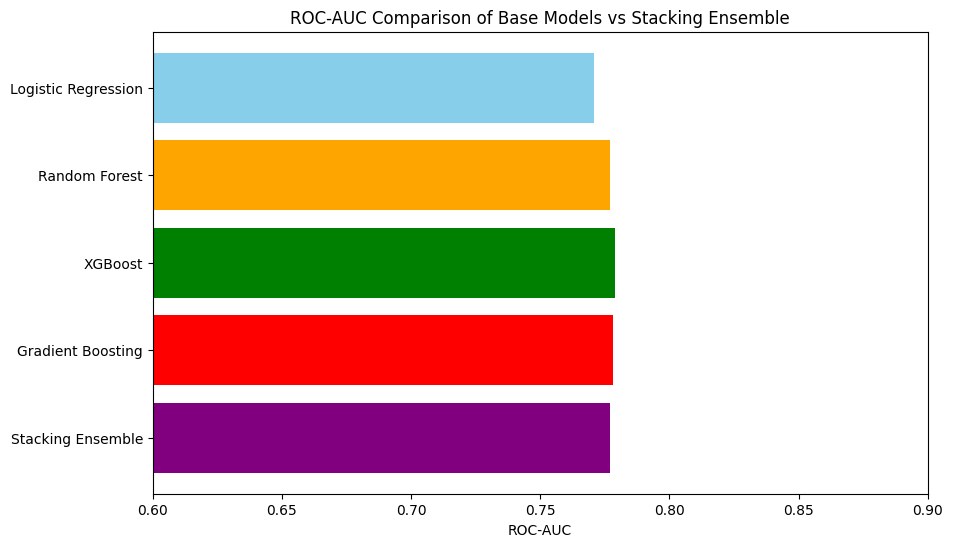

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Example results data
results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "Gradient Boosting", "Stacking Ensemble"],
    "ROC-AUC": [0.771, 0.777, 0.779, 0.778, 0.777]
})

# Plot
plt.figure(figsize=(10,6))
plt.barh(results_df["Model"], results_df["ROC-AUC"], color=['skyblue','orange','green','red','purple'])
plt.xlabel("ROC-AUC")
plt.title("ROC-AUC Comparison of Base Models vs Stacking Ensemble")
plt.xlim(0.6, 0.9)
plt.gca().invert_yaxis()
plt.show()
